# End-to-End Analysis and Visualization of E3SM Data using UXarray and xCDAT

E3SM Tutorial Workshop 2024

05/07/2024

Authors: [Tom Vo](https://github.com/tomvothecoder) and [Stephen Po-Chedley](https://github.com/pochedls)


## Overview

This exercise notebook will walkthrough and example end-to-end analysis workflow of E3SM
native format data using UXarray and xCDAT. It explores the capabilities of UXarray and xCDAT
at a high-level, including grid analysis and computational operations. Towards the end
there will brief coverage of parallelizing Xarray-based operations using Dask.


1. Open E3SM Data with Grid Files using UXarray
2. Run some UXarray operations (e.g., view )
3. Transform the data to make it compatible with xCDAT
4. Use xCDAT for post-processing operations
5. Visualize data
6. Advanced users: parallelizing operations (Dask Schedulers)


## Setup


In [1]:
import glob
import warnings

import numpy as np
import xarray as xr
import xcdat as xc
import uxarray as ux

# The data directory containing the NetCDF files.
# TODO: Update to perlmutter directory
data_dir = "/p/user_pub/work/E3SM/1_0/1950-Control-21yrContHiVol-HR/0_25deg_atm_18-6km_ocean/atmos/native/model-output/mon/ens1/v1/"
# The absolute paths to each NetCDF file in the data directory.
data_paths = glob.glob(data_dir + "*.nc")

# The path to the grid file.
grid_path = "/p/user_pub/e3sm/grids_maps/grids/ne120.g"

## I/O and Computations with UXarray

UXarray offers support for loading and representing unstructured grids by providing Xarray-like functionality paired with new routines that are specifically written for operating on unstructured grids.

Source: https://uxarray.readthedocs.io/en/latest/examples/001-working-with-unstructured-grids.html#


### Exercise 1. Open E3SM Dataset with Grid Files using UXarray

When working with Unstructured Grids, the grid definition and data variables are often stored as separate files. This means that there are multiple separate files that need to be read and linked together to represent the entire dataset.

A `ux.Dataset` object is an `xarray.Dataset-like`, multi-dimensional, in memory, array database. Inherits from `xarray.Dataset` and has its own unstructured grid-aware dataset operators and attributes through the uxgrid accessor.

Source: https://uxarray.readthedocs.io/en/latest/getting-started/overview.html


#### 💻 Your turn:

Use `ux.open_mfdataset()` to open the grid file and the NetCDF files as a `ux.Dataset` object.

Hint: Use `grid_path` and `data_paths` as function arguments.


In [8]:
# Your code here. When ready, click on the three dots below for the solution.

In [2]:
uxds = ux.open_mfdataset(grid_path, data_paths[0:1])

### Exercise 2: Visualize the Grid Topology

https://uxarray.readthedocs.io/en/latest/examples/006-plot-api-topology.html


#### 💻 Your turn:

Extract the grid topology from the `uxds` and plot it.

Hint: Use the `.uxgrid` attribute and call `.plot()`


In [ ]:
# Your code here. When ready, click on the three dots below for the solution.

In [ ]:
grid = uxds.uxgrid
grid.plot(title="Default Grid Plot Method", height=350, width=700)

### Exercise 3: Grid Calculations

TODO: https://uxarray.readthedocs.io/en/latest/examples/003-area-calc.html


#### 💻 Your turn:

Calculate the total face area for the grid.all

Hint: Use `.calculate_total_face_area()`


In [ ]:
# Your code here. When ready, click on the three dots below for the solution.

In [15]:
t4_area = grid.calculate_total_face_area()
t4_area

### Exercise 4: Subsetting an Unstructured Grid

TODO: https://uxarray.readthedocs.io/en/latest/examples/009-subsetting.html#


In [23]:
uxds.TS.subset

<uxarray.UxDataArray.subset>
Supported Methods:
  * nearest_neighbor(center_coord, k, element, **kwargs)
  * bounding_circle(center_coord, r, element, **kwargs)
  * bounding_box(lon_bounds, lat_bounds, element, method, **kwargs)

In [24]:
uxds.TS.uxgrid.subset

<uxarray.Grid.subset>
Supported Methods:
  * nearest_neighbor(center_coord, k, element, **kwargs)
  * bounding_circle(center_coord, r, element, **kwargs)
  * bounding_box(lon_bounds, lat_bounds, element, method, **kwargs)

## Temporal Computations with xCDAT

In the examples below, we will performing temporal computations on the `Uxarray.Dataset`
object (`uxds`) using xCDAT.


### First, check CF attributes are set correctly in the dataset.

xCDAT requires CF attributes to be set on axes in order for the APIs
to map to them for operations.

For example, the time axis should have CF attributes such as `axis="T"` or
`axis="standard_name"` to interpret.


In [6]:
uxds.cf

Coordinates:
             CF Axes: * Z: ['ilev', 'lev']
                      * T: ['time']
                        X, Y: n/a

      CF Coordinates: * vertical: ['ilev', 'lev']
                      * time: ['time']
                        longitude, latitude: n/a

       Cell Measures:   area, volume: n/a

      Standard Names: * atmosphere_hybrid_sigma_pressure_coordinate: ['ilev', 'lev']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   T: ['time_bnds']
                        cosp_ht: ['cosp_ht_bnds']
                        cosp_htmisr: ['cosp_htmisr_bnds']
                        cosp_prs: ['cosp_prs_bnds']
                        cosp_sr: ['cosp_sr_bnds']
                        cosp_tau: ['cosp_tau_bnds']
                        cosp_tau_modis: ['cosp_tau_modis_bnds']
                        time: ['time_bnds']

       Grid Mappings:   n/a

## Decode the time coordinates (TEMPORARY)

FIXME: UXarray removes the hard-coded `decode_times=False` in this [PR](https://github.com/UXARRAY/uxarray/pull/767). Once UXarray 2024.04.01 is released, we drop `xr.decode_cf` calls.

- `ux.open_dataset()` and `ux.open_mfdataset()` set `decode_times=False`.
- An extra call to `xr.decode_cf()` is required to decode time coordinates before
  using xCDAT temporal averaging APIs.
- **WARNING: This will convert a `uxarray.UxDataset` to an `xarray.Dataset`, which means UXarray attributes and operators will no longer be available on the object.**


In [53]:
uxds_cf = xr.decode_cf(uxds, decode_times=True, use_cftime=True)

In [24]:
uxds_cf["T"].time

<xarray.DataArray 'time' (time: 2)> Size: 16B
array([cftime.DatetimeNoLeap(58, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(75, 9, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 16B 0058-09-01 00:00:00 0075-09-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

### Exercise 1 - Single-snapshot average


#### 💻 Your turn:

Calculate the single-snapshot average of the variable "TREFHT"


In [19]:
# Your code here. When ready, click on the three dots below for the solution.

In [25]:
uxds_cf.temporal.average("T")["T"]

<xarray.DataArray 'T' (lev: 72, ncol: 777602)> Size: 448MB
dask.array<truediv, shape=(72, 777602), dtype=float64, chunksize=(72, 777602), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 576B 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
Dimensions without coordinates: ncol
Attributes:
    mdims:         9
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean
    operation:     temporal_avg
    mode:          average
    freq:          year
    weighted:      True

### Exercise 2 - Group Average


#### 💻 Your turn:

Calculate the daily group average of the variable "TREFHT"


In [ ]:
# Your code here. When ready, click on the three dots below for the solution.

In [26]:
uxds.temporal.group_average("T", freq="day")["T"]

<xarray.DataArray 'T' (time: 2, lev: 72, ncol: 777602)> Size: 896MB
dask.array<truediv, shape=(2, 72, 777602), dtype=float64, chunksize=(1, 72, 777602), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 576B 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * time     (time) object 16B 0058-09-01 00:00:00 0075-09-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         9
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean
    operation:     temporal_avg
    mode:          group_average
    freq:          day
    weighted:      True

### Exercise 3 - Climatology


#### 💻 Your turn:

Calculate the daily climatology of the variable "TREFHT".


In [ ]:
# Your code here. When ready, click on the three dots below for the solution.

In [27]:
uxds_cf.temporal.climatology("T", freq="day")["T"]

<xarray.DataArray 'T' (time: 1, lev: 72, ncol: 777602)> Size: 448MB
dask.array<truediv, shape=(1, 72, 777602), dtype=float64, chunksize=(1, 72, 777602), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 576B 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * time     (time) object 8B 0001-09-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         9
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean
    operation:     temporal_avg
    mode:          climatology
    freq:          day
    weighted:      True

### Exercise 4 - Departures


#### 💻 Your turn:

Calculate the daily departures of the variable "TREFHT".


In [ ]:
# Your code here. When ready, click on the three dots below for the solution.

In [28]:
uxds_cf.temporal.departures("T", freq="day")["T"]

<xarray.DataArray 'T' (time: 2, lev: 72, ncol: 777602)> Size: 896MB
dask.array<sub, shape=(2, 72, 777602), dtype=float64, chunksize=(1, 72, 777602), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 576B 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * time     (time) object 16B 0058-09-01 00:00:00 0075-09-01 00:00:00
Dimensions without coordinates: ncol
Attributes:
    mdims:         9
    units:         K
    long_name:     Temperature
    cell_methods:  time: mean
    operation:     temporal_avg
    mode:          departures
    freq:          day
    weighted:      True

## Spatial Computations with xCDAT

In the examples below, we will performing spatial computations on the `Uxarray.Dataset`
object (`uxds`) using xCDAT.


### 1. Regrid 2D fields from E3SM column format to a user-defined rectilinear grid

xCDAT's spatial averager operates on rectilinear grids, which requires latitude and
longitude coordinates.

This section is already done for you. Just run the cells and proceed forward to the spatial
averaging exercise.


In [14]:
# required packages
import numpy as np
import xarray as xr
from scipy import spatial
import xcdat as xc


def simple_regrid(
    ds: xr.Dataset,
    target_var: str,
    nlat: xr.DataArray,
    nlon: xr.DataArray,
    infill: bool = True,
) -> xr.Dataset:
    """
    Nearest neighbor mapping of 2D fields from E3SM column format to a
    user-defined rectilinear grid.

    Parameters:
    -----------
    ds : xr.Dataset
        Source dataset to remap
    target_var : str
        Name of variable to remap
    nlat : xr.DataArray
        Target latitude values
    nlon : xr.DataArray
        Target longitude values
    infill : bool
        Flag to infill (with extrapolation) missing values (default True)

    Returns:
    --------
    xr.Dataset

    Notes:
    ------
    This regridding tool is intended as a simple regridding tool and is not fit
    for most scientific applications, but may be useful for data quick-looks.
    """
    dset_out = []

    # Loop over time steps and remap one map at a time.
    for i in range(len(ds.time)):
        # Get data
        lat = ds.lat
        lon = ds.lon
        data = ds[target_var].isel(time=i)

        # Target grid
        LON, LAT = np.meshgrid(nlon, nlat)
        shp = LAT.shape

        # Create a nearest-neighbor tree for the grid
        tree = spatial.cKDTree(list(zip(LAT.flat, LON.flat)))
        _, ind = tree.query(np.array([lat, lon]).T)
        n = tree.n

        # Sum of data in each grid box
        X = np.bincount(ind, weights=data, minlength=n)
        # Total number of matches
        cnt = np.bincount(ind, weights=np.ones_like(data), minlength=n)

        # Going to get divide by zero here for grid boxes with no data
        with np.errstate(divide="ignore", invalid="ignore"):
            grid = X / cnt

        # Reshape to regular grid
        grid = grid.reshape(shp)
        grid = xr.DataArray(
            data=grid,
            dims=["lat", "lon"],
            coords={"lat": nlat, "lon": nlon},
            name=target_var,
        )
        dset_out.append(grid)

    # Concatenate time steps and create xr.Dataset
    ds_final = xr.concat(dset_out, dim=ds.time).to_dataset()

    # Incorporate bounds from original dataset
    if "time_bnds" in ds.data_vars:
        ds_final["time_bnds"] = ds.time_bnds

    # Add missing bounds
    ds_final = ds_final.bounds.add_missing_bounds(["X", "Y", "T"])

    # Infill (if desired)
    if infill:
        ds_final[target_var] = ds_final[target_var].interpolate_na(
            dim="lon", method="nearest", fill_value="extrapolate"
        )

    return ds_final

In [15]:
# Define regrid targets
target_var = "TREFHT"
nlat, _ = xc.create_axis(
    "lat",
    np.arange(-88.75, 90, 2.5),
    attrs={"axis": "Y", "units": "degrees_north"},
    generate_bounds=False,
)
nlon, _ = xc.create_axis(
    "lon",
    np.arange(1.25, 360, 2.5),
    attrs={"axis": "X", "units": "degrees_east"},
    generate_bounds=False,
)

# call simple regridder
uxds_r = simple_regrid(uxds, target_var, nlat, nlon)

In [5]:
uxds_r

<xarray.Dataset> Size: 88kB
Dimensions:    (lat: 72, lon: 144, time: 1, nbnd: 2, bnds: 2)
Coordinates:
  * lat        (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) float64 8B 2.105e+04
Dimensions without coordinates: nbnd, bnds
Data variables:
    TREFHT     (time, lat, lon) float64 83kB 212.7 215.0 214.6 ... 271.9 271.9
    time_bnds  (time, nbnd) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 2kB 0.0 2.5 2.5 5.0 ... 357.5 357.5 360.0
    lat_bnds   (lat, bnds) float64 1kB -90.0 -87.5 -87.5 ... 87.5 87.5 90.0

### 2. Plot the first time step

#### 💻 Your turn:

Plot the first time step for the regridded variable.

Hint: Use `.plot()`


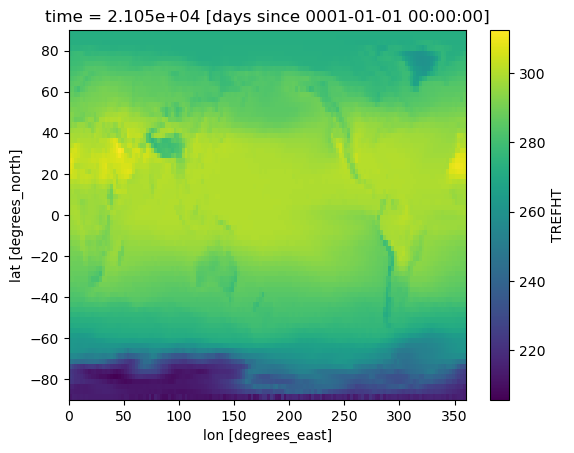

In [6]:
uxds_r["TREFHT"][0].plot()

In [ ]:
### Exercise 

In [7]:
uxds_r_avg = uxds_r.spatial.average(target_var)

In [8]:
uxds_r_avg

<xarray.Dataset> Size: 5kB
Dimensions:    (lat: 72, lon: 144, time: 1, nbnd: 2, bnds: 2)
Coordinates:
  * lat        (lat) float64 576B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) float64 8B 2.105e+04
Dimensions without coordinates: nbnd, bnds
Data variables:
    TREFHT     (time) float64 8B 288.7
    time_bnds  (time, nbnd) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 2kB 0.0 2.5 2.5 5.0 ... 357.5 357.5 360.0
    lat_bnds   (lat, bnds) float64 1kB -90.0 -87.5 -87.5 ... 87.5 87.5 90.0